In [1]:
from __future__ import print_function

import re
import numpy as np
import csv, json
from zipfile import ZipFile
from os.path import expanduser, exists
import pandas as pd
import datetime, time, json

from keras.models import Model, Sequential
from keras.layers import Input, TimeDistributed, Bidirectional, LSTM, Dense, Lambda, concatenate, Dropout, BatchNormalization, Convolution1D, Merge, Flatten
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
QUESTION_PAIRS_FILE = 'data/train.csv'
GLOVE_FILE = 'data/glove.840B.300d.txt'
Q1_TRAINING_DATA_FILE = 'data/q1_train.npy'
Q2_TRAINING_DATA_FILE = 'data/q2_train.npy'
LABEL_TRAINING_DATA_FILE = 'data/label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'data/word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'data/nb_words.json'
MAX_NB_WORDS = 200000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300

In [3]:
STOP_WORDS = ['ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
SAFE_DIV = 0.0001

In [4]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

In [5]:
question1 = []
question2 = []
is_duplicate = []
with open(QUESTION_PAIRS_FILE, encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        question1.append(preprocess(row['question1']))
        question2.append(preprocess(row['question2']))
        is_duplicate.append(row['is_duplicate'])
print('Question pairs: %d' % len(question1))

Question pairs: 404290


In [6]:
questions = question1 + question2
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(questions)
question1_word_sequences = tokenizer.texts_to_sequences(question1)
question2_word_sequences = tokenizer.texts_to_sequences(question2)
word_index = tokenizer.word_index

print("Words in index: %d" % len(word_index))

Words in index: 91458


In [7]:
embeddings_index = {}
with open(GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

Word embeddings: 2196016


In [8]:
nb_words = min(MAX_NB_WORDS, len(word_index))
word_embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

print('Null word embeddings: %d' % np.sum(np.sum(word_embedding_matrix, axis=1) == 0))


Null word embeddings: 24937


In [9]:
q1_data = pad_sequences(question1_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
q2_data = pad_sequences(question2_word_sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(is_duplicate, dtype=int)
print('Shape of question1 data tensor:', q1_data.shape)
print('Shape of question2 data tensor:', q2_data.shape)
print('Shape of label tensor:', labels.shape)


Shape of question1 data tensor: (404290, 25)
Shape of question2 data tensor: (404290, 25)
Shape of label tensor: (404290,)


In [10]:
np.save(open(Q1_TRAINING_DATA_FILE, 'wb'), q1_data)
np.save(open(Q2_TRAINING_DATA_FILE, 'wb'), q2_data)
np.save(open(LABEL_TRAINING_DATA_FILE, 'wb'), labels)
np.save(open(WORD_EMBEDDING_MATRIX_FILE, 'wb'), word_embedding_matrix)
with open(NB_WORDS_DATA_FILE, 'w') as f:
    json.dump({'nb_words': nb_words}, f)

In [11]:
#Model Variables
MODEL_WEIGHTS_FILE = 'question_pairs_weights_lstm.h5'
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1
RNG_SEED = 13371447
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32
nb_filter = 32 # Number of filters to use in Convolution1D
filter_length = 3 # Length of filter for Convolution1D
SENT_EMBEDDING_DIM = 128

In [12]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]


In [13]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question3 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question4 = Input(shape=(MAX_SEQUENCE_LENGTH,))
q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q1)

q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q2)

q3 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question3)

q3 = Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q3)
q3 = Flatten()(q3)
#q3 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q3)

q4 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question4)
q4 =Bidirectional(LSTM(SENT_EMBEDDING_DIM, return_sequences=True), merge_mode="sum")(q4)
q4 = Flatten()(q4)

merged = concatenate([q1,q2,q3,q4])
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
merged = Dense(200, activation='relu')(merged)
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)
is_duplicate = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2,question3,question4], outputs=is_duplicate)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_

In [15]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train,Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2018-05-02 15:58:40.909171
Train on 327474 samples, validate on 36387 samples
Epoch 1/25
 - 1421s - loss: 0.5301 - acc: 0.7333 - val_loss: 0.4758 - val_acc: 0.7657
Epoch 2/25
 - 1403s - loss: 0.4574 - acc: 0.7793 - val_loss: 0.4357 - val_acc: 0.7898
Epoch 3/25
 - 1396s - loss: 0.4107 - acc: 0.8084 - val_loss: 0.4224 - val_acc: 0.7999
Epoch 4/25
 - 1396s - loss: 0.3610 - acc: 0.8364 - val_loss: 0.4073 - val_acc: 0.8079
Epoch 5/25
 - 1395s - loss: 0.3117 - acc: 0.8647 - val_loss: 0.4142 - val_acc: 0.8109
Epoch 6/25
 - 1395s - loss: 0.2636 - acc: 0.8894 - val_loss: 0.4151 - val_acc: 0.8134
Epoch 7/25
 - 1396s - loss: 0.2252 - acc: 0.9073 - val_loss: 0.4247 - val_acc: 0.8112
Epoch 8/25
 - 1396s - loss: 0.1951 - acc: 0.9217 - val_loss: 0.4536 - val_acc: 0.8119
Epoch 9/25
 - 1395s - loss: 0.1718 - acc: 0.9318 - val_loss: 0.4534 - val_acc: 0.8134
Epoch 10/25
 - 1396s - loss: 0.1572 - acc: 0.9379 - val_loss: 0.4863 - val_acc: 0.8151
Epoch 11/25
 - 1397s - loss: 0.1464 - ac

    epoch  training  validation
0       1  0.733344    0.765713
1       2  0.779268    0.789815
2       3  0.808431    0.799901
3       4  0.836375    0.807871
4       5  0.864685    0.810921
5       6  0.889417    0.813367
6       7  0.907324    0.811169
7       8  0.921743    0.811911
8       9  0.931805    0.813422
9      10  0.937940    0.815126
10     11  0.942951    0.806359
11     12  0.946912    0.813175
12     13  0.951947    0.812708
13     14  0.954262    0.809465
14     15  0.955920    0.812488
15     16  0.960259    0.814577
16     17  0.961829    0.812570
17     18  0.964977    0.816858
18     19  0.965787    0.815841
19     20  0.967756    0.814274
20     21  0.968947    0.814412
21     22  0.969524    0.809987
22     23  0.970703    0.815264
23     24  0.972447    0.819029
24     25  0.972941    0.817462


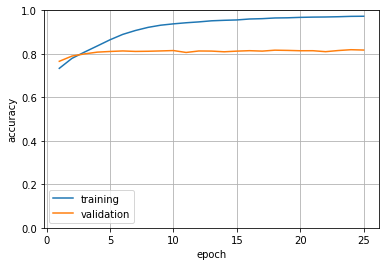

In [23]:
import matplotlib
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']})
print(acc)
ax = acc.iloc[:,:].plot(x='epoch',  grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

In [21]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))
model.load_weights(MODEL_WEIGHTS_FILE)


Maximum accuracy at epoch 24 = 0.8190


In [22]:
loss, accuracy = model.evaluate([Q1_test, Q2_test,Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.5869, accuracy = 0.8170
